In [1]:
import tensorflow as tf

In [2]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()

In [3]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [4]:
tokenizer.fit_on_texts(data)

In [5]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


In [6]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [7]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [8]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [9]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [10]:
def sequence_to_name(sequence):
  return ''.join([index_to_char[i] for i in sequence if i != 0])

In [11]:
print(sequence_to_name([25, 16, 12, 20, 2, 1]))

jumpa	


In [12]:
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences  += [seq[:i] for i in range(2, len(seq)+1)]

In [13]:
print(sequences[:10])
print(len(sequences))
max_len = max([len(seq) for seq in sequences])
print(max_len)

[[25, 16], [25, 16, 12], [25, 16, 12, 20], [25, 16, 12, 20, 2], [25, 16, 12, 20, 2, 1], [14, 5], [14, 5, 15], [14, 5, 15, 9], [14, 5, 15, 9, 5], [14, 5, 15, 9, 5, 4]]
88279
33


In [14]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre', maxlen=max_len
)
print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [15]:
padded_sequences.shape

(88279, 33)

In [16]:
x, y = padded_sequences[:, :-1], padded_sequences[:, -1]

In [17]:
print(x.shape, y.shape)

(88279, 32) (88279,)


In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [19]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM, Bidirectional, Dense

In [22]:
model = Sequential([
                    Embedding(num_chars, 8, input_length=max_len-1),
                    Conv1D(64, 5, strides=1, activation='relu', padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 8)             232       
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            2624      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 29)                957       
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
_________________________________________________________________


In [23]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, verbose=2,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
    ]
)

Epoch 1/50
2070/2070 - 48s - loss: 2.7486 - accuracy: 0.1917 - val_loss: 2.5733 - val_accuracy: 0.2237
Epoch 2/50
2070/2070 - 16s - loss: 2.5191 - accuracy: 0.2390 - val_loss: 2.4822 - val_accuracy: 0.2491
Epoch 3/50
2070/2070 - 16s - loss: 2.4542 - accuracy: 0.2543 - val_loss: 2.4344 - val_accuracy: 0.2633
Epoch 4/50
2070/2070 - 17s - loss: 2.4067 - accuracy: 0.2690 - val_loss: 2.4010 - val_accuracy: 0.2709
Epoch 5/50
2070/2070 - 16s - loss: 2.3715 - accuracy: 0.2815 - val_loss: 2.3733 - val_accuracy: 0.2856
Epoch 6/50
2070/2070 - 16s - loss: 2.3412 - accuracy: 0.2914 - val_loss: 2.3530 - val_accuracy: 0.2928
Epoch 7/50
2070/2070 - 17s - loss: 2.3132 - accuracy: 0.3014 - val_loss: 2.3317 - val_accuracy: 0.2987
Epoch 8/50
2070/2070 - 17s - loss: 2.2885 - accuracy: 0.3096 - val_loss: 2.3173 - val_accuracy: 0.3009
Epoch 9/50
2070/2070 - 17s - loss: 2.2660 - accuracy: 0.3146 - val_loss: 2.2988 - val_accuracy: 0.3072
Epoch 10/50
2070/2070 - 16s - loss: 2.2453 - accuracy: 0.3208 - val_loss:

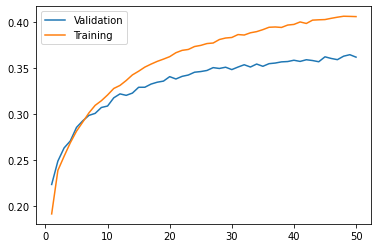

In [25]:
import matplotlib.pyplot as plt

epochs_ran = len(h.history['loss'])

plt.plot(range(1, epochs_ran+1), h.history['val_accuracy'], label='Validation')
plt.plot(range(1, epochs_ran+1), h.history['accuracy'], label='Training')
plt.legend()
plt.show()

In [39]:
def generate_names(seed):
  for i in range(40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre',
                                                           maxlen=max_len-1,
                                                           truncating='pre')
    prediction = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(prediction).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  return seed

In [45]:
print(generate_names('gr'))

green arrow	
